# DCGAN for brain MRI slices

We use a DCGAN to generate slices of brain MRI images. 

### Set up imports

In [1]:
import os

import torch
import torch.nn as nn
from torch.utils.data import random_split
import torch.optim as optim

import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.data import DataLoader
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
    Randomizable
)

from typing import Union, Sequence

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import SelectChanneld

### Preprocessing pipeline

The data we use is 3D so we write a simple transform which selects a slice from the 3D image. 

In [2]:
class Sliced(MapTransform, Randomizable):

    """Transform to extract three consecutive slices containing
    a nontrivial segmentation. The location is uniformly selected
    from the center region"""

    def __init__(self, keys, seed: int = None, allow_missing_keys: bool = False):

        Randomizable.set_random_state(self, seed=seed)
        MapTransform.__init__(self, keys, allow_missing_keys)

    def __call__(self, data):
        """
        Args:
            data (Mapping): dictionary to transform"""

        d = dict(data)
        c = self.R.randint(25,35)

        for key in self.key_iterator(d):
            d[key] = d[key][:,:,:,c]
        return d

In [3]:
# transforms

train_transform = Compose(
    [
        LoadImaged(keys="image"),
        AsChannelFirstd(keys="image"),
        SelectChanneld("image", 0),
        Spacingd(
            keys="image",
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear"),
        ),
        Orientationd(keys="image", axcodes="RAS"),
        RandSpatialCropd(
            keys="image", roi_size=[128, 128, 64], random_size=False
        ),
        RandFlipd(keys="image", prob=0.5, spatial_axis=0),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
        Sliced("image"),
        ToTensord(keys="image"),
    ]
)

val_transform = Compose(
    [
        LoadImaged(keys="image"),
        AsChannelFirstd(keys="image"),
        SelectChanneld("image", 0),
        Spacingd(
            keys="image",
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear"),
        ),
        Orientationd(keys="image", axcodes="RAS"),
        CenterSpatialCropd(keys="image", roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        Sliced("image"),
        ToTensord(keys="image"),
        ]
)

### Dataloading

In [4]:
root_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/'
batch_size = 4

# training dataset
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=False,
    num_workers=4,
    cache_num= 50 # 100
)

# validation dataset
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    num_workers=4,
    cache_num= 25 # 4
)

# dataloaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"\nNumber of training points = {len(train_ds)}.\n")
print(f"Number of validation points = {len(val_ds)}.\n")

Loading dataset: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Number of training points = 388.

Number of validation points = 96.



### Visualize examples: whitish and bright spots are tumor regions

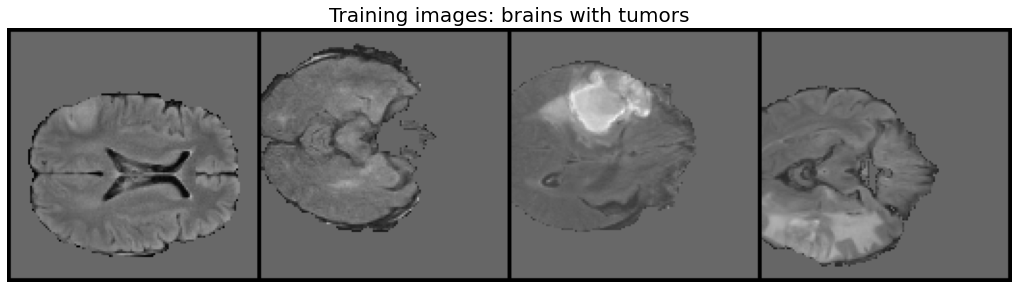

In [5]:
# Plot some training images
real_batch = next(iter(train_loader))
real_batch = real_batch["image"]
plt.figure(figsize=(18,18))
plt.axis("off")
plt.title("Training images: brains with tumors", size = 20)
plt.imshow(np.transpose(vutils.make_grid(real_batch[:64], padding=2, normalize=True, vmin=-2, vmax=2).cpu(),(1,2,0)))
plt.show()

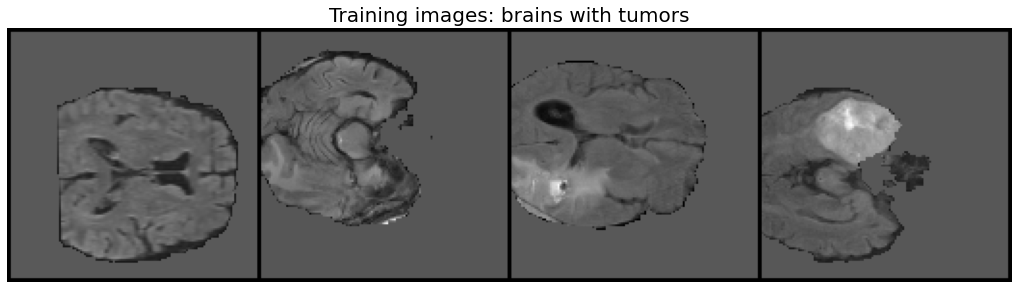

In [8]:
# Plot some training images
real_batch = next(iter(train_loader))
real_batch = real_batch["image"]
plt.figure(figsize=(18,18))
plt.axis("off")
plt.title("Training images: brains with tumors", size = 20)
plt.imshow(np.transpose(vutils.make_grid(real_batch[:64], padding=2, normalize=True, vmin=-2, vmax=2).cpu(),(1,2,0)))
plt.show()

## Network components

The images are 128 x 128 so our generator will output tensors of size 128 x 128, and the discriminator will take such tensor size too.

In [43]:
class Generator(nn.Module):
    """
    Args:
        nz = size of latent vector z
        ngf = size of feature maps
        nc = number of channels in training images
    """

    def __init__(self, nz: int =  100, ngf: int = 128, nc: int = 1):
        super().__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)
    

class Discriminator(nn.Module):
    """
    Args:
        ndf = size of feature maps
        nc = number of channels in training images
    """
    def __init__(self, nc: int = 1, ndf: int = 128):
        super().__init__()
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
# Helper function to initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Instantiate network

In [50]:
# size of latent vector
nz = 100

# Batch size during training
batch_size = 4

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# device
device = torch.device("cuda:0")

To avoid vanishing gradients coming from the sigmoid activation function on the discriminator, we use ``nn.BCEWithLogitsLoss`` instead which allows us to remove the ``nn.Sigmoid`` from the discriminator steps.

In [51]:
D =  Discriminator().to(device)
G = Generator().to(device)

# initialize weights with normal dist
G.apply(weights_init)
D.apply(weights_init)

# Loss
criterion = nn.BCEWithLogitsLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

# Training loop

In [52]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
mean_G_losses =[]
mean_D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):
        real_batch = data["image"].to(device)

        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D.zero_grad()
        # Format batch
        b_size = real_batch.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = D(real_batch).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = G(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        

        # (2) Update G network: maximize log(D(G(z)))
        ####################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # create images out of fixed noise
        if (iters % 25 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    # mean losses to plot
    mean_D_losses.append(np.mean(D_losses))
    mean_G_losses.append(np.mean(G_losses))
    if epoch % 2 == 0:
        print(f'{epoch}/{num_epochs}\tmean Loss_D: {np.mean(D_losses) : .3f}\t mean Loss_G: {np.mean(G_losses) : .3f}')

Starting Training Loop...
0/100	mean Loss_D:  5.376	 mean Loss_G:  65.757
2/100	mean Loss_D:  4.147	 mean Loss_G:  31.241
4/100	mean Loss_D:  3.098	 mean Loss_G:  23.864
6/100	mean Loss_D:  2.504	 mean Loss_G:  21.590
8/100	mean Loss_D:  2.119	 mean Loss_G:  20.483
10/100	mean Loss_D:  1.875	 mean Loss_G:  20.152
12/100	mean Loss_D:  1.705	 mean Loss_G:  19.803
14/100	mean Loss_D:  1.572	 mean Loss_G:  19.196
16/100	mean Loss_D:  1.460	 mean Loss_G:  19.017
18/100	mean Loss_D:  1.414	 mean Loss_G:  19.172
20/100	mean Loss_D:  1.347	 mean Loss_G:  19.003
22/100	mean Loss_D:  1.284	 mean Loss_G:  18.994
24/100	mean Loss_D:  1.234	 mean Loss_G:  18.893
26/100	mean Loss_D:  1.183	 mean Loss_G:  18.690
28/100	mean Loss_D:  1.139	 mean Loss_G:  18.483
30/100	mean Loss_D:  1.103	 mean Loss_G:  18.365
32/100	mean Loss_D:  1.076	 mean Loss_G:  18.357
34/100	mean Loss_D:  1.041	 mean Loss_G:  18.149
36/100	mean Loss_D:  1.006	 mean Loss_G:  17.930
38/100	mean Loss_D:  0.985	 mean Loss_G:  17.709

### Plot losses for D and G:

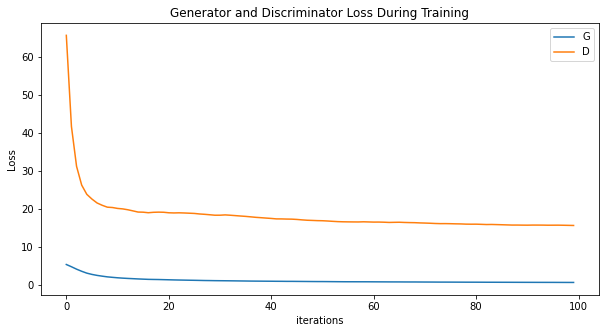

In [53]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(mean_D_losses,label="G")
plt.plot(mean_G_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"losses_{num_epochs}.png")
plt.show()

### Visualize images with most updated model

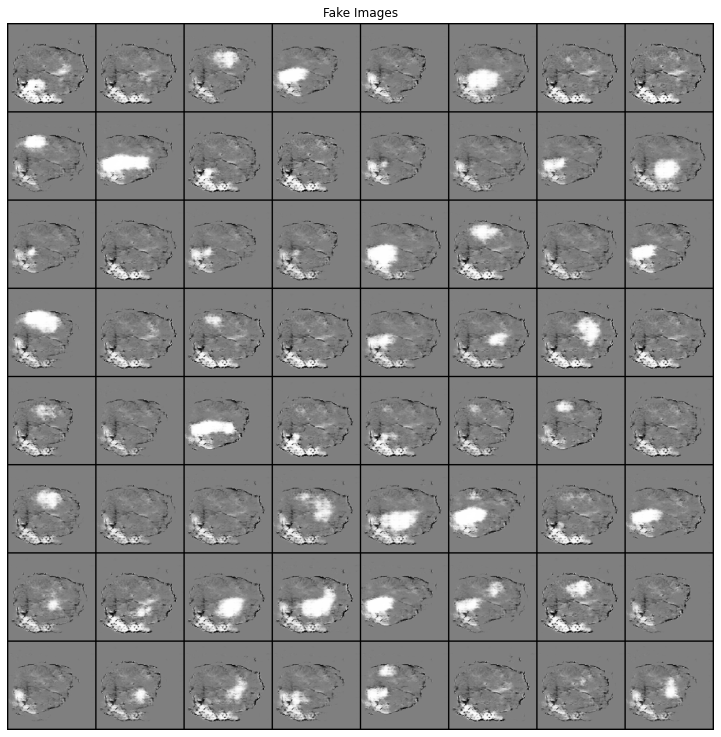

In [67]:
# Plot the fake images from the last epoch
plt.figure(figsize=(13,13))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('b.png')
plt.show()